# Ablation study

**Objetivo:** Comparar los resultados obtenidos en los distintos pasos vs un enfoque baseline


# Dependencies

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone
from catboost import CatBoostClassifier, CatBoostRegressor

from config import TREATMENT, OUTCOME, SEED
from utils.potential_outcomes import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
)


from utils.preprocessing import create_stratification_split_col
from utils.linear_regression import build_sm_regression_formula
from utils.error_estimates import get_ci_estimation_results

warnings.filterwarnings("ignore")

# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"
DATA_GENERATOR_PATH = 'data/data_generator.pkl'

In [3]:
step = 1
bin_edges = np.arange(0, 100+step, step)

In [4]:
colors = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "aiptw": "lightblue",
}

In [5]:
est_methods = ["s_learner"]
n_iterations = 3

In [6]:
np.random.seed(SEED)

# Utils

In [7]:
def print_results(results_dict, est_methods):
    for est_method in est_methods:
        results_method = results_dict[est_method]
        mean_error = results_method["estimation-error"]["average"].mean()
        var_error = results_method["estimation-error"]["average"].var()
        error_lower_bound = results_method["estimation-error"]["lower_bound"].mean()
        error_upper_bound = results_method["estimation-error"]["upper_bound"].mean()
        print(f"{est_method}:")
        print(f"Mean RMSE: {mean_error:.4f}, [{error_lower_bound:.4}-{error_upper_bound:.4}]")
        print(f"Mean Variance RMSE: {var_error:.4f}")


# Data

In [8]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls


['n_loans',
 'n_cards',
 'loss_given_default',
 'debt_cirbe',
 'default_debt_amount',
 'years_since_default',
 'n_refin']

In [9]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['months_since_first_payment', 'years_history', 'n_accounts']

In [10]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

In [11]:
with open(DATA_GENERATOR_PATH, 'rb') as file:
    generator = pickle.load(file)

# Split

In [12]:
strat_feature = create_stratification_split_col(df_original, TREATMENT, OUTCOME)
train, test = train_test_split(
    df_original, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + outcome_causes + [TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
test_original = df_original.loc[test.index, :]
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(14387, 11) (12000, 411) (3000, 411)


# Estimation without Dimensionality Reduction + Identification

In [13]:
monotone_constraints_list = []

for f in list(X_train.columns):
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [14]:
results_baseline = {}
adjustment_set_baseline = [c for c in train.columns if c not in [TREATMENT, OUTCOME]]
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set_baseline,
        outcome_causes=[],
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    results_baseline[est_method] = results_method

print_results(results_baseline, est_methods)

s_learner
s_learner:
Mean RMSE: 0.3892, [0.3849-0.3929]
Mean Variance RMSE: 0.0016


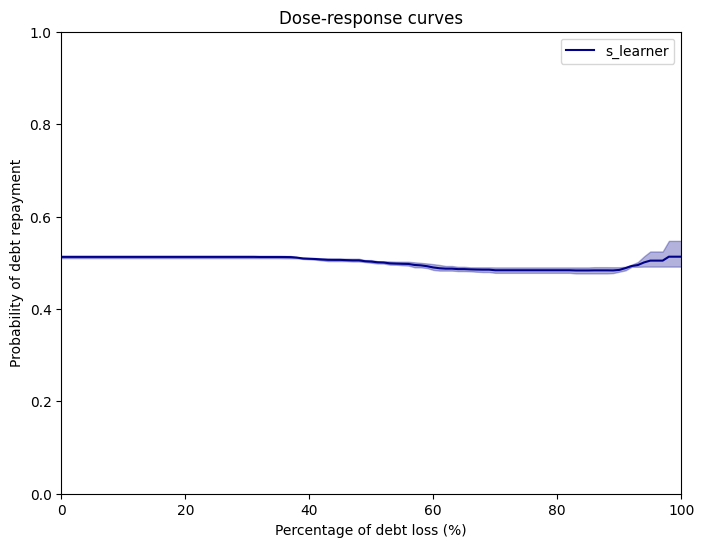

In [15]:
plt.figure(figsize=(8, 6))
for method, results_method in results_baseline.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

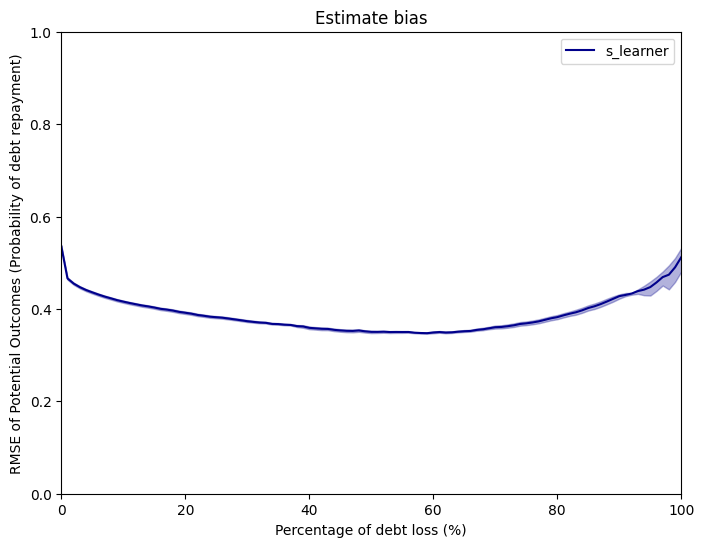

In [16]:
plt.figure(figsize=(8, 6))
for method, results_method in results_baseline.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Estimation with confounders and without data-augmentation

In [17]:
monotone_constraints_list = []
adjustment_set = controls + outcome_causes

for f in controls + outcome_causes+[TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [18]:
results_adjustment_set = {}


for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set,
        outcome_causes=outcome_causes,
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    # print(results_method)
    results_adjustment_set[est_method] = results_method
print_results(results_adjustment_set, est_methods)

s_learner
s_learner:
Mean RMSE: 0.3394, [0.3293-0.3483]
Mean Variance RMSE: 0.0007


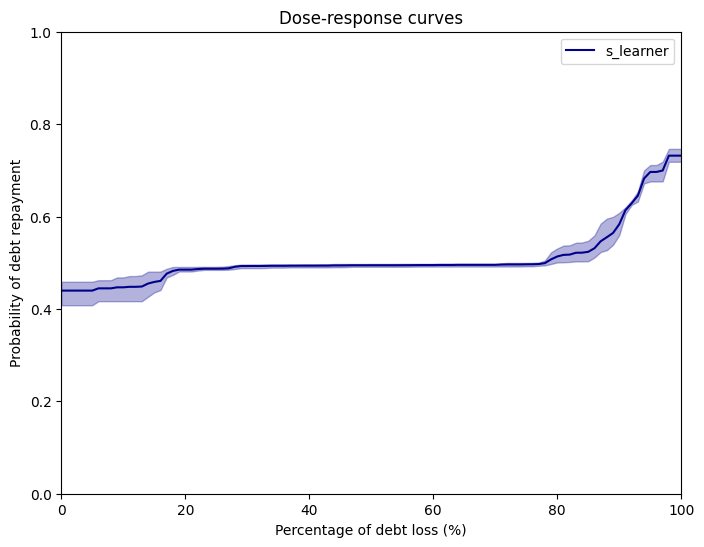

In [19]:
plt.figure(figsize=(8, 6))
for method, results_method in results_adjustment_set.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

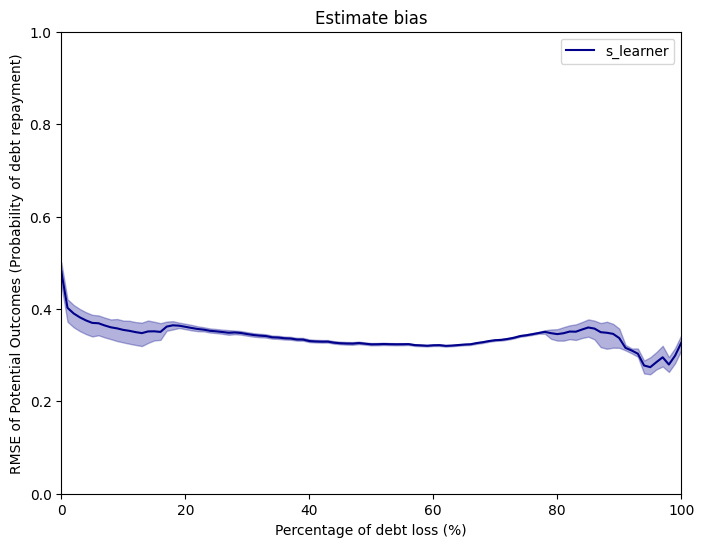

In [20]:
plt.figure(figsize=(8, 6))
for method, results_method in results_adjustment_set.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Proposed Estimation

In [21]:
monotone_constraints_list = []
adjustment_set = controls + outcome_causes

for f in adjustment_set+[TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [22]:
results_pipeline = {}
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set,
        outcome_causes=outcome_causes,
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    results_pipeline[est_method] = results_method
print_results(results_pipeline, est_methods)

s_learner
s_learner:
Mean RMSE: 0.2335, [0.2279-0.2392]
Mean Variance RMSE: 0.0021


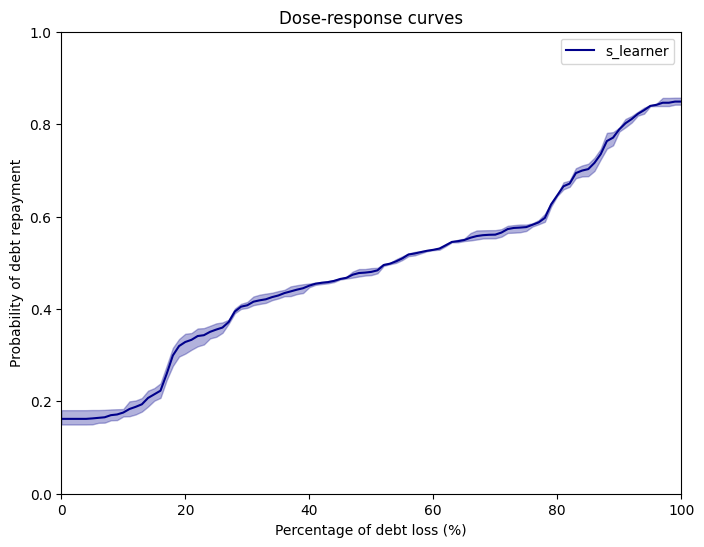

In [23]:
plt.figure(figsize=(8, 6))
for method, results_method in results_pipeline.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

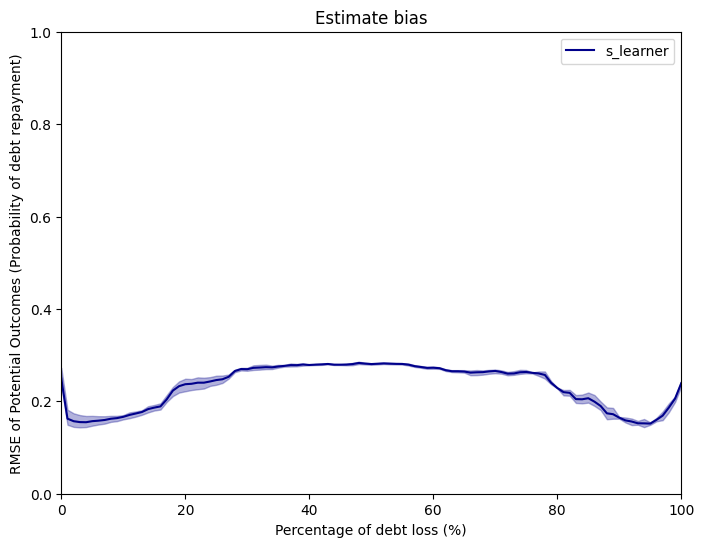

In [24]:
plt.figure(figsize=(8, 6))
for method, results_method in results_pipeline.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Comparison

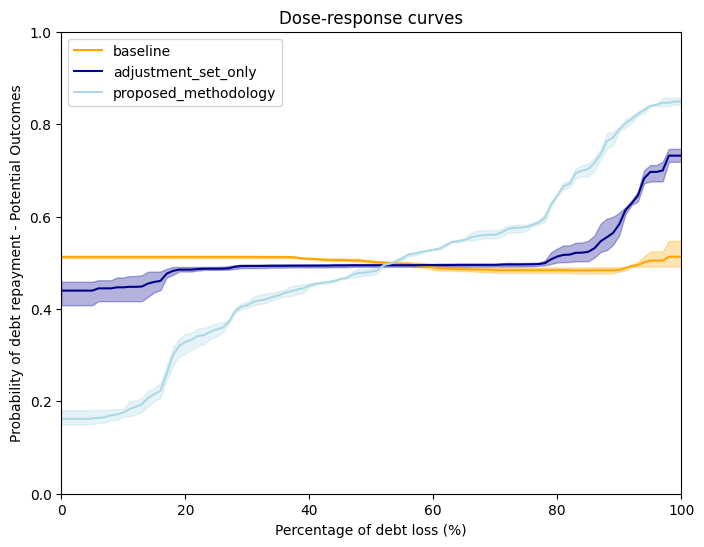

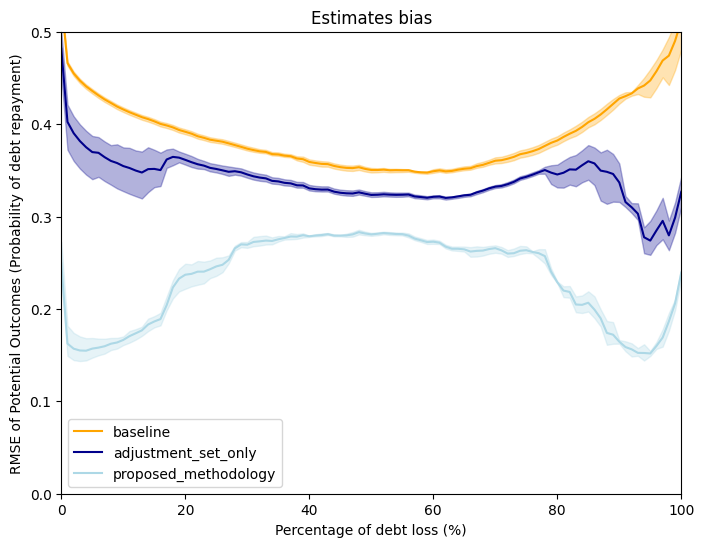

In [25]:
ablation_study = {
    "baseline": results_baseline,
    "adjustment_set_only": results_adjustment_set,
    "proposed_methodology": results_pipeline,
}
colors = {
    "baseline": "orange",
    "adjustment_set_only": "darkblue",
    "proposed_methodology": "lightblue",
}


plt.figure(figsize=(8, 6))
for method, results_method in ablation_study.items():
    plt.plot(
        bin_edges,
        results_method[est_methods[0]]["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method[est_methods[0]]["dose-response"]["lower_bound"],
        results_method[est_methods[0]]["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("Probability of debt repayment - Potential Outcomes")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()


plt.figure(figsize=(8, 6))
for method, results_method in ablation_study.items():
    plt.plot(
        bin_edges,
        results_method[est_methods[0]]["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method[est_methods[0]]["estimation-error"]["lower_bound"],
        results_method[est_methods[0]]["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimates bias")
plt.legend()
plt.ylim(0, 0.5)
plt.xlim(0, 100)
plt.show()

In [26]:
ablation_study = {
    "baseline": results_baseline,
    "adjustment_set_only": results_adjustment_set,
    "proposed_methodology": results_pipeline,
}
colors = {
    "baseline": "orange",
    "adjustment_set_only": "darkblue",
    "proposed_methodology": "lightblue",
}


errors_table = pd.DataFrame(columns=["methodology", "estimation_method", "mean_estimation_bias", "estimation_bias_variance", "[0.05","0.95]"], index=range(len(ablation_study.keys())))

for i, (method, results_ditc_methodology) in enumerate(ablation_study.items()):
    results_method = results_ditc_methodology[est_methods[0]]
    mean_error = results_method["estimation-error"]["average"].mean()
    var_error = results_method["estimation-error"]["average"].var()
    error_lower_bound = results_method["estimation-error"]["lower_bound"].mean()
    error_upper_bound = results_method["estimation-error"]["upper_bound"].mean()
    errors_table.loc[i, :] = [method, est_methods[0], mean_error, var_error, error_lower_bound, error_upper_bound]


errors_table

,methodology,estimation_method,mean_estimation_bias,estimation_bias_variance,[0.05,0.95]
0,baseline,s_learner,0.389172,0.001578,0.384889,0.392914
1,adjustment_set_only,s_learner,0.339443,0.000673,0.329328,0.348255
2,proposed_methodology,s_learner,0.23346,0.002144,0.227946,0.239156
